# Import

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# 创建数据集

In [2]:
words = open("../data/names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
chars = sorted(set("".join(words)))
stoi = { s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")
    return X, Y

import random
random.seed(11)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3
Xtr, Ytr = build_dataset(words[:n1], block_size) # 80%
Xval, Yval = build_dataset(words[n1:n2], block_size) # 10%
Xte, Yte = build_dataset(words[n2:], block_size) # 10%

X.shape: torch.Size([182306, 3]), Y.shape: torch.Size([182306])
X.shape: torch.Size([22885, 3]), Y.shape: torch.Size([22885])
X.shape: torch.Size([22955, 3]), Y.shape: torch.Size([22955])


# 初始化模型参数

In [5]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(11)
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"模型参数量: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

模型参数量: 4137


# 一次训练

In [6]:
batch_size = 32
n = batch_size

# mini-batch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

emb = C[Xb] # (n, block_size, n_embd)
embcat = emb.view(emb.shape[0], -1) # (block_size, n_embd)
# Linear layer 1
hprebn = embcat @ W1 + b1 # (n, n_hidden) hidden layer pre-batchnorm
# Batch Normalization
bnmeani = hprebn.mean(0, keepdim=True) # (1, n_hidden)
bndiff = hprebn - bnmeani # (n, n_hidden)
bndiff2 = bndiff ** 2 # (n, n_hidden)
bnvar = 1 / (n-1) * bndiff2.sum(0, keepdim=True) # (1, n_hidden)
bnstd_inv = (bnvar + 1e-5) ** -0.5 # (1, n_hidden)
bnraw = bndiff * bnstd_inv # (n, n_hidden)
hpreact = bngain * bnraw + bnbias # (n, n_hidden) hidden layer pre-activation
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2 # (n, vocab_size)
# cross entropy loss
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes # numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logits_maxes,
    logits, h, hpreact, bnraw, bnstd_inv, bnvar, bndiff2, bndiff, bnmeani,
    hprebn, embcat, emb]:
    t.retain_grad()
loss.backward()
loss.item()

3.184386730194092

# Exercise 1
backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one


In [7]:
def cmp(des: str, dt: torch.Tensor, t: torch.Tensor):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{des:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [8]:
# -----------------
# YOUR CODE HERE :)
# -----------------

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs + dcounts_sum
dnorm_logits = counts * dcounts
dlogits_maxes = -dnorm_logits.sum(1, keepdim=True)
dlogits = dnorm_logits + F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = dhpreact * bngain
dbndiff = bnstd_inv * dbnraw
dbnstd_inv = (dbnraw * bndiff).sum(0, keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5) ** -1.5 * dbnstd_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = -dbndiff.sum(0, keepdim=True)
dhprebn += torch.ones_like(dhprebn) / n * dbnmeani
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
dC.index_add_(0, Xb.view(-1), demb.view(-1, 10))

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('count', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogits_maxes, logits_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bndiff', dbndiff, bndiff)
cmp('bnstd_inv', dbnstd_inv, bnstd_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('embcat', dembcat, embcat)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
count           | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

# Exercise 2
backprop through cross_entropy but all in one go to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out

In [9]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.1843864917755127 diff: -2.384185791015625e-07


In [10]:
logits.shape

torch.Size([32, 27])

In [11]:
F.softmax(logits, dim=1).sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [12]:
logits[range(n), Yb].shape

torch.Size([32])

In [13]:
# -----------------
# YOUR CODE HERE :)
# -----------------
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


In [14]:
dlogits.sum(1)

tensor([ 9.3132e-10,  2.7940e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.3970e-09, -9.3132e-10,  4.6566e-10, -1.8626e-09,  1.3970e-09,
         0.0000e+00,  2.5611e-09,  0.0000e+00, -9.3132e-10,  1.3970e-09,
        -1.3970e-09,  1.1642e-09,  2.7940e-09,  0.0000e+00,  3.2596e-09,
        -2.7940e-09,  0.0000e+00,  1.8626e-09,  3.2596e-09, -3.7253e-09,
         1.8626e-09,  0.0000e+00,  2.3283e-10,  1.8626e-09, -1.1642e-09,
         2.3283e-09,  0.0000e+00], grad_fn=<SumBackward1>)

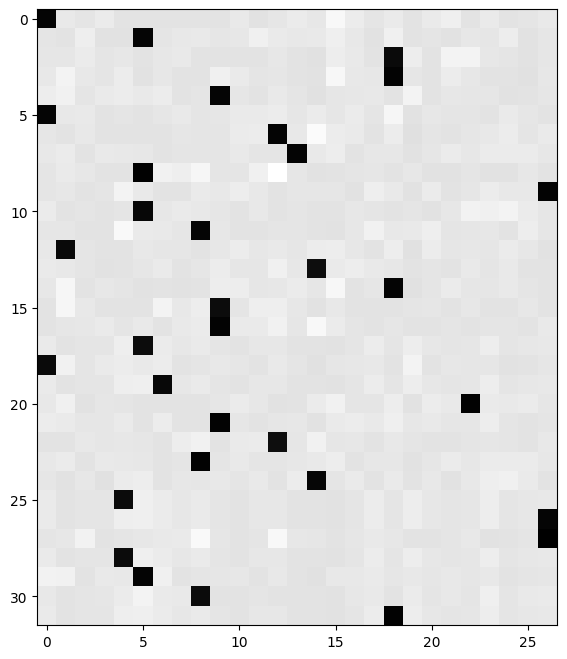

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

# Exercise 3
backprop through batchnorm but all in one go to complete this challenge look at the mathematical expression of the output of batchnorm, take the derivative w.r.t. its input, simplify the expression, and just write it out

BatchNorm paper: https://arxiv.org/abs/1502.03167

In [16]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True) + 1e-5) + bnbias
print('maxdiff:', (hpreact_fast - hpreact).abs().max().item())

maxdiff: 4.76837158203125e-07


In [17]:
# -----------------
# YOUR CODE HERE :)
# -----------------
dhprebn = bngain * bnstd_inv / n * (n*dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))


cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


# Exercise 4: putting it all together!
Train the MLP neural net with your own backward pass

In [18]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(11)
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"模型参数量: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():
    for i in range(max_steps):
        # mini-batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        emb = C[Xb] # (n, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1) # (block_size, n_embd)
        # Linear layer 1
        hprebn = embcat @ W1 + b1 # (n, n_hidden) hidden layer pre-batchnorm
        # Batch Normalization
        bnmean = hprebn.mean(0, keepdim=True) # (1, n_hidden)
        bnvar = hprebn.var(0, keepdim=True) # (1, n_hidden)
        bnstd_inv = (bnvar + 1e-5) ** -0.5 # (1, n_hidden)
        bnraw = (hprebn - bnmean) * bnstd_inv # (n, n_hidden)
        hpreact = bngain * bnraw + bnbias # (n, n_hidden) hidden layer pre-activation
        # Non-linearity
        h = torch.tanh(hpreact)
        # Linear layer 2
        logits = h @ W2 + b2 # (n, vocab_size)
        # cross entropy loss
        loss = F.cross_entropy(logits, Yb)

        #backward pass
        for p in parameters:
            p.grad = None
        # loss.backward()

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)
        # -----------------


        dlogits = F.softmax(logits, dim=1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1 - h**2) * dh
        # batch norm
        dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * bnstd_inv / n * (n*dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        dembcat = dhprebn @ W1.T
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        dC.index_add_(0, Xb.view(-1), demb.view(-1, 10))

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # update
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data -= lr * grad

        # track states
        if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

模型参数量: 12297
      0/ 200000: 3.5885
  10000/ 200000: 2.1829
  20000/ 200000: 2.5900
  30000/ 200000: 2.2509
  40000/ 200000: 2.4163
  50000/ 200000: 2.0518
  60000/ 200000: 1.9870
  70000/ 200000: 2.0319
  80000/ 200000: 2.4171
  90000/ 200000: 2.2434
 100000/ 200000: 1.9944
 110000/ 200000: 2.0146
 120000/ 200000: 2.1014
 130000/ 200000: 1.9279
 140000/ 200000: 2.1212
 150000/ 200000: 2.1258
 160000/ 200000: 2.3256
 170000/ 200000: 2.3546
 180000/ 200000: 1.9543
 190000/ 200000: 2.1863


In [20]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [21]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

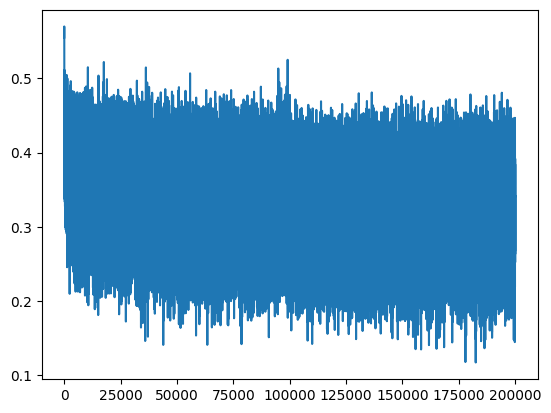

In [22]:
plt.plot(lossi)

# 训练效果

In [23]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (n, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (block_size, n_embd)
    # Linear layer 1
    hprebn = embcat @ W1 + b1 # (n, n_hidden) hidden layer pre-batchnorm
    # Batch Normalization
    bnstd_inv = (bnvar + 1e-5) ** -0.5 # (1, n_hidden)
    bnraw = (hprebn - bnmean) * bnstd_inv # (n, n_hidden)
    hpreact = bngain * bnraw + bnbias # (n, n_hidden) hidden layer pre-activation
    # Non-linearity
    h = torch.tanh(hpreact)
    # Linear layer 2
    logits = h @ W2 + b2 # (n, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.07295298576355
val 2.119002342224121


# Embedding可视化

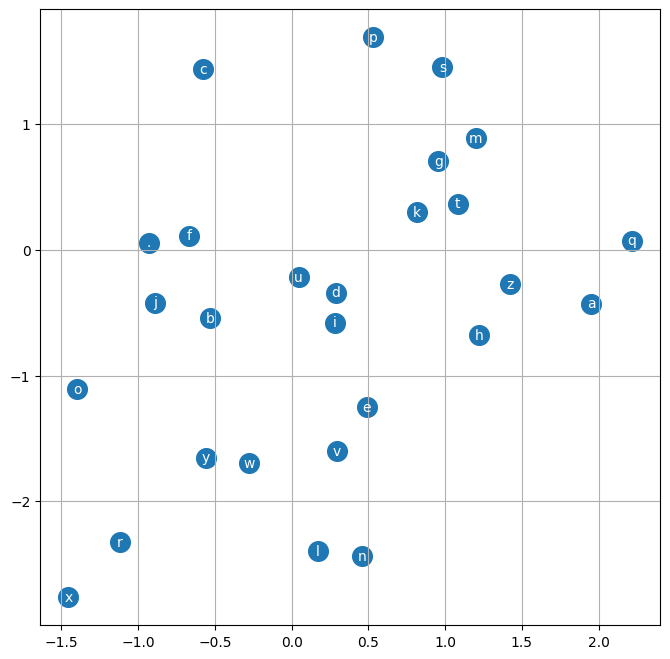

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

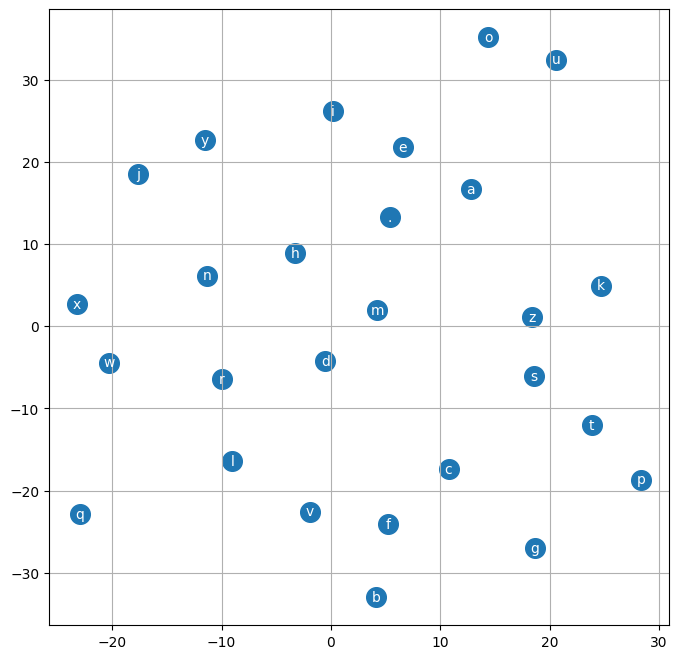

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=10)
tsne_emb = tsne.fit_transform(C.data.numpy())

plt.figure(figsize=(8, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=200)
for i in range(tsne_emb.shape[0]):
    plt.text(tsne_emb[i, 0], tsne_emb[i, 1], itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# 使用模型生成名字

In [26]:
sample_size = 20

g = torch.Generator().manual_seed(11 + 10)

for _ in range(sample_size):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (n, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1) # (block_size, n_embd)
        # Linear layer 1
        hprebn = embcat @ W1 + b1 # (n, n_hidden) hidden layer pre-batchnorm
        # Batch Normalization
        bnstd_inv = (bnvar + 1e-5) ** -0.5 # (1, n_hidden)
        bnraw = (hprebn - bnmean) * bnstd_inv # (n, n_hidden)
        hpreact = bngain * bnraw + bnbias # (n, n_hidden) hidden layer pre-activation
        # Non-linearity
        h = torch.tanh(hpreact)
        # Linear layer 2
        logits = h @ W2 + b2 # (n, vocab_size)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print("".join([itos[i] for i in out]))

hadomi
lucie
brah
rubinoah
avin
matte
kyndinnlo
rovia
emik
avaliah
amari
knia
giannirahiyanna
benki
davlani
isco
maevoriah
maddinelookabbrille
zar
aiwon
